<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
</center>
Авторы материала: аспирант Мехмата МГУ Евгений Колмаков, программист-исследователь Mail.ru Group Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3. Опциональная часть 
## <center> Реализация алгоритма построения дерева решений

In [293]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error

**Необходимо реализовать класс `DecisionTree`**

**Спецификация:**
- класс наследуется от `sklearn.BaseEstimator`;
- конструктор содержит следующие параметры: 
    `max_depth` - максимальная глубина дерева (по умолчанию - `numpy.inf`); 
    `min_samples_split` - минимальное число объектов в вершине, при котором происходит её разбиение (по умолчанию - 2); 
    `criterion` - критерий разбиения (для классификации - 'gini' или 'entropy', для регрессии - 'variance' или 'mad_median'; 
    по умолчанию - 'gini');
    
    Функционал, значение которого максимизируется для поиска оптимального разбиения в данной вершине имеет вид
    $$Q(X, j, t) = F(X) - \dfrac{|X_l|}{|X|} F(X_l) - \dfrac{|X_r|}{|X|} F(X_r),$$
    где $X$ - выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ - разбиение выборки $X$ на две части 
    по предикату $[x_j < t]$, а $F(X)$ -критерий разбиения.
    
    Для классификации: пусть $p_i$ - доля объектов $i$-го класса в выборке $X$.
    
    'gini': Неопределенность Джини $F(X) = 1 -\sum_{i = 1}^K p_i^2$.
    
    'entropy': Энтропия $F(X) = -\sum_{i = 1}^K p_i \log_2(p_i)$.
    
    Для регрессии: $y_j = y(x_j)$ - ответ на объекте $x_j$, $y = (y_1, \dots, y_{|X|})$ - вектор ответов.
    
    'variance': Дисперсия (среднее квадратичное отклонение от среднего) $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j - \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2$
    
    'mad_median': Среднее отклонение от медианы $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}|y_j - \mathrm{med}(y)|$
    
- класс имеет методы `fit`, `predict` и `predict_proba`;
- метод `fit` принимает матрицу объектов `X` и вектор ответов `y` (объекты `numpy.ndarray`) и возвращает экземпляр класса
    `DecisionTree`, представляющий собой решающее дерево, обученное по выборке `(X, y)` с учётом заданных в конструкторе параметров; 
- метод `predict_proba` принимает матрицу объектов `X` и возвращает матрицу `P` размера `X.shape[0] x K`, где `K` - число классов, такую что $p_{ij}$ есть вероятность принадлежности объекта, заданного $i$-ой строкой матрицы X к классу $j \in \{1, \dots, K\}$.
- метод `predict` принимает матрицу объектов и возвращает вектор предсказанных ответов; в случае классификации - это 
    наиболее многочисленный класс в листе, в который попал объект, а в случае регрессии - среднее значение ответов по 
    всем объектам этого листа;

In [294]:
def prob(y):
    _, counts = np.unique(y, return_counts=True)
    return counts/len(y)

In [295]:
def entropy(y):    
    p = prob(y)
    return -sum(p*np.log2(p))

def gini(y):
    return 1 - sum(prob(y)**2)

def variance(y):
    m = np.mean(y)
    return sum((y - m)**2)/len(y)

def mad_median(y):
    med = np.median(y)
    return sum(np.abs(y - med))/len(y)

In [296]:
a = [1,2,3,4]
entropy(a), gini(a),  variance(a), mad_median(a)

(2.0, 0.75, 1.25, 1.0)

In [297]:
class Leaf():
    value_counts = None
    is_final = False
    left = None
    right = None
    p_values = None
    mean = None
    t = None
    j = None
    Q = None

In [298]:
class DecisionTree(BaseEstimator):
    
    def __init__(self, max_depth=np.inf, min_samples_split=2, 
                 criterion='gini', debug=False):
        self.max_depth=max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.debug = debug
    
    def fit(self, X, y):
        
        if self.criterion == 'gini':
            self.F = gini
        elif self.criterion == 'entropy':
            self.F = entropy
        elif self.criterion == 'variance':
            self.F = variance
        elif self.criterion == 'mad_median':
            self.F = mad_median
        else:
            raise ValueError('Unknown criterion')
            
        if self.max_depth < 1:
            raise ValueError('max_depth should be at least 1')    

        # Построим список уникальных классов
        self.classes = np.unique(y)
                             
        # Построение дерева проще всего сделать итеративным
        self.tree = self.create_leaf(X, y, 0)
         
        return self
        
            
    def create_leaf(self, X, y, cur_depth):
        
        # Внутри каждого поддерева
        l = Leaf()
                        
        # Проверить критерии выхода - min_samples_split, max_depth, все элементы одного класса
        if len(y) < self.min_samples_split or cur_depth >= self.max_depth or len(np.unique(y)) == 1 \
            or self.no_unique_t(X):
            # Если это конец, подсчитать среднее (для регрессии), p для всех классов (для классификации)
            l.is_final = True
                             
            # Регрессия
            if self.criterion in ('variance','mad_median'):
                l.mean = np.mean(y)
            # Классификация
            else:
                l.p_values = []
                for c in self.classes:
                    l.p_values.append(sum(y == c)/len(y))                
        else:
            # Если нет, то найти лучшее разбиение, и отправить в рекурсивный поиск по долям
            Xl, yl, Xr, yr, l.Q, l.j, l.t = self.find_split(X,y)
            
            l.left = self.create_leaf(Xl, yl, cur_depth + 1)
            l.right = self.create_leaf(Xr, yr, cur_depth + 1)
        
            l.value_counts = (len(yl),len(yr))
        
        return l
    
    def no_unique_t(self, X):
        
        result = True
        
        for j in range(X.shape[1]):
            if len(np.unique(X[:,j])) > 1:
                result = False
        
        return result
            
    
    def find_split(self, X, y):
        
        Q_max = -np.inf
        t_max = -np.inf
        j_max = -1
        
        F = self.F
        
        # Для каждого признака сделать поиск по значениям
        for j in range(X.shape[1]):
            
            if self.debug:
                print('j', j)
                print('X', X)
                print('X.shape[1]',X.shape[1])
            
            
            # Отобрать все значения признака
            # Отсортировать вместе с y (* найти только те, при которых меняется признак)
            # Найти уникальные
            Xju = np.unique(X[:,j])
            
            # Найти t значения между уникальными 
            t_candidates = (Xju[:-1] + Xju[1:])/2
            
            if self.debug:
                print('t_candidates', t_candidates)
            
            # Перебрать все значения t для признака
            for t in t_candidates:
                
                # Расчитаем Q
                yl = y[X[:,j] < t]
                yr = y[X[:,j] >= t]

                Q = F(y) - (len(yl)/len(y))*F(yl) - (len(yr)/len(y))*F(yr)
            
                if self.debug:
                    print('Max j:{} t:{} Q:{}'.format(j, t, Q))
            
                # Если признак и порог t максимизируют Q_max, использовать его как новый максимум
                if Q > Q_max:
                    Q_max = Q
                    t_max = t
                    j_max = j

        # На основе найденного признака вернем Xl, yl, Xr, yr, Q_max, j, t
        Xl = X[X[:,j_max] < t_max]
        yl = y[X[:,j_max] < t_max]
        Xr = X[X[:,j_max] >= t_max]
        yr = y[X[:,j_max] >= t_max]
        
        return Xl, yl, Xr, yr, Q_max, j_max, t_max
    
    
    def predict(self, X):
        
        result = []
        
        for Xv in X:
            leaf = self.get_final_leaf(self.tree, Xv)
        
            # Регрессия
            if self.criterion in ('variance','mad_median'):
                result.append(leaf.mean)
            # Классификация
            else:
                result.append(self.classes[np.argmax(leaf.p_values)])
                
        return result
        
    
    def get_final_leaf(self, leaf, Xv):
        
        if leaf.is_final == True:
            return leaf
        
        else:
            if Xv[leaf.j] < leaf.t:
                return self.get_final_leaf(leaf.left, Xv)
            else:
                return self.get_final_leaf(leaf.right, Xv)
        
        
    def predict_proba(self, X):
        
        if self.criterion in ('variance','mad_median'):
            raise Exception('Unable to calculate probabilities for exceptions')
        
        result = np.arange(len(df_opt.classes))
        
        for Xv in X:
            leaf = self.get_final_leaf(self.tree, Xv)

            result = np.vstack((result, leaf.p_values))
            
            if self.debug:
                print('leaf.p_values', leaf.p_values)
        
        result = result[1:,:]
            
        return result

## Тестирование реализованного алгоритма

### Классификация

С помощью метода `load_digits` загрузите датасет `digits`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие решающие деревья и убедитесь, что критерии gini и entropy дают разные результаты.

In [299]:
digits = load_digits()

In [300]:
dt = DecisionTree()
%time dt.fit(digits.data, digits.target)

CPU times: user 5 s, sys: 0 ns, total: 5 s
Wall time: 5 s


DecisionTree(criterion='gini', debug=False, max_depth=inf,
       min_samples_split=2)

In [301]:
X_train, X_valid, y_train, y_valid = train_test_split(digits.data, digits.target, test_size=0.2, random_state=17)

In [302]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1437, 64), (360, 64), (1437,), (360,))

С помощью 5-кратной кросс-валидации (`GridSearchCV`) подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - range(3, 11), а для criterion - {'gini', 'entropy'}. Критерий качества `scoring`='accuracy'.

In [303]:
tree = DecisionTree()
tree_params = {'max_depth': list(range(3, 11)), 'criterion':['gini', 'entropy']}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True, scoring='accuracy')
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTree(criterion='gini', debug=False, max_depth=inf,
       min_samples_split=2),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=True)

Постройте графики средних значений критерия качества `accuracy` для критериев `gini` и `entropy` в зависимости от `max_depth`.

In [304]:
scores_gini = tree_grid.cv_results_['mean_test_score'][tree_grid.cv_results_['param_criterion'] == 'gini']
scores_entropy = tree_grid.cv_results_['mean_test_score'][tree_grid.cv_results_['param_criterion'] == 'entropy']
max_depth_gini = tree_grid.cv_results_['param_max_depth'][tree_grid.cv_results_['param_criterion'] == 'gini']

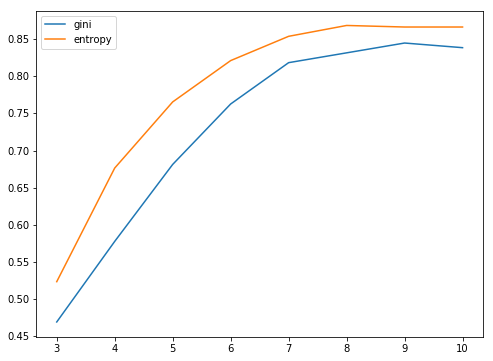

In [305]:
plt.figure(figsize=(8,6))
plt.plot(range(3,11), scores_gini, range(3,11), scores_entropy)
plt.legend(labels=['gini','entropy']);


**Выберите верные утверждения:**
1. Оптимальное значение max_depth для каждого критерия достигается внутри отрезка [3, 10] (то есть на отрезке [4, 9]).
2. На отрезке [3, 10] построенные графики не пересекаются.
3. На отрезке [3, 10] построенные графики пересекаются ровно один раз.
4. Наилучшее качество при max_depth на интервале [3, 10] достигается на критерии gini.
5. Хотя бы для одного из критериев значение accuracy строго возрастает с ростом значения max_depth на интервале [3, 10].

Ответ: 1,2

**Чему равны найденные оптимальные значения параметров max_depth и criterion?**
1. max_depth = 4, criterion = 'gini';
2. max_depth = 7, criterion = 'entropy';
3. max_depth = 10, criterion = 'entropy';
4. max_depth = 10, criterion = 'gini';
5. max_depth = 3, criterion = 'entropy';
6. max_depth = 9, criterion = 'gini';

Ответ: 'criterion': 'entropy', 'max_depth': 8

In [307]:
tree_grid.best_params_

{'criterion': 'entropy', 'max_depth': 8}

Используя найденные оптимальные значения max_depth и criterion, обучите решающее дерево на X_train, y_train и вычислите вероятности принадлежности к классам для X_test.

In [308]:
df_opt2 = DecisionTree(max_depth=8, criterion='entropy')
df_opt2.fit(X_train, y_train)

DecisionTree(criterion='entropy', debug=False, max_depth=8,
       min_samples_split=2)

In [309]:
res2 = df_opt2.predict(X_valid)

In [310]:
res2[0:10], y_valid[0:10]

([1, 8, 7, 1, 9, 5, 8, 9, 8, 1], array([1, 2, 7, 3, 9, 5, 8, 9, 8, 1]))

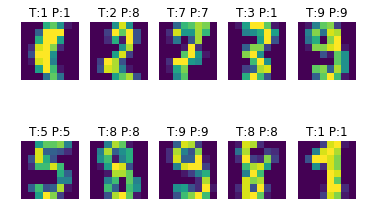

In [311]:
for i in range(10):    
    plt.subplot(2,5, i+1)
    plt.imshow(np.reshape(X_valid[i],(8,8)))
    plt.axis('off');
    plt.title('T:{} P:{}'.format(y_valid[i], res2[i]))
    
    

In [312]:
accuracy_score(y_valid, df_opt2.predict(X_valid))

0.8777777777777778

In [313]:
result = df_opt2.predict_proba(X_valid)

In [314]:
np.mean(result, axis=0)

array([0.09166667, 0.07422504, 0.10021605, 0.08930086, 0.12690476,
       0.11898148, 0.07916667, 0.09583333, 0.11076173, 0.11294341])

In [315]:
np.max(np.mean(result, axis=0))

0.12690476190476194

Для полученной матрицы вычислите усредненные по всем объектам из `X_test` значения вероятностей принадлежности к классам.

**Вопрос:** Чему равна максимальная вероятность в полученном векторе?
1. 0.11218791
2. 0.11783761
3. 1.0
4. 0.0875

Ответ: 0.12690476190476194, не совпадает с вариантами.

### Регрессия

С помощью метода `load_boston` загрузите датасет `boston`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие регрессионные деревья и убедитесь, что критерии `variance` и `mad_median` дают разные результаты.

In [316]:
boston=load_boston()

In [317]:
X_train, X_valid, y_train, y_valid = train_test_split(boston.data, boston.target, test_size=0.2, random_state=17)

In [318]:
dt1 = DecisionTree(criterion='variance', max_depth=3)
dt1.fit(boston.data, boston.target)
vars(dt1.tree)

{'Q': 38.22046447905717,
 'j': 5,
 'left': <__main__.Leaf at 0x7f0986f7efd0>,
 'right': <__main__.Leaf at 0x7f09850bd710>,
 't': 6.941,
 'value_counts': (430, 76)}

In [319]:
dt2 = DecisionTree(criterion='mad_median', max_depth=3)
dt2.fit(boston.data, boston.target)
vars(dt2.tree)

{'Q': 1.554347826086955,
 'j': 5,
 'left': <__main__.Leaf at 0x7f0984944c50>,
 'right': <__main__.Leaf at 0x7f09849e57b8>,
 't': 6.797,
 'value_counts': (413, 93)}

С помощью 5-кратной кросс-валидации подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - `range(2, 9)`, а для `criterion` - {'variance', 'mad_median'}. Критерий качества `scoring`='neg_mean_squared_error'.

In [320]:
tree = DecisionTree()
tree_params = {'max_depth': list(range(2, 9)), 'criterion':['variance', 'mad_median']}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True, scoring='neg_mean_squared_error')
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   49.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTree(criterion='gini', debug=False, max_depth=inf,
       min_samples_split=2),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'criterion': ['variance', 'mad_median'], 'max_depth': [2, 3, 4, 5, 6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=True)

In [321]:
scores_variance = tree_grid.cv_results_['mean_test_score'][tree_grid.cv_results_['param_criterion'] == 'variance']
scores_mad_median = tree_grid.cv_results_['mean_test_score'][tree_grid.cv_results_['param_criterion'] == 'mad_median']

Постройте графики средних значений критерия качества `neg_mean_squared_error` для критериев `variance` и `mad_median` в зависимости от `max_depth`.

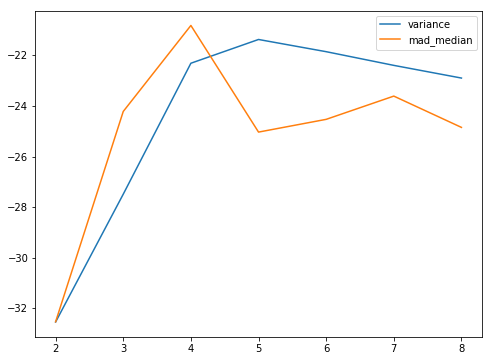

In [322]:
plt.figure(figsize=(8,6))
plt.plot(range(2,9), scores_variance, range(2,9), scores_mad_median)
plt.legend(labels=['variance','mad_median']);

**Выберите верные утверждения:**
1. На отрезке [2, 8] построенные графики не пересекаются.
2. На отрезке [2, 8] построенные графики пересекаются ровно один раз.
3. Оптимальное значение max_depth для каждого из критериев достигается на границе отрезка [2, 8].
4. Наилучшее качество при max_depth in range(2, 9) достигается на критерии variance.
5. График качества ровно для одного из критериев имеет явно выраженный пик.

Ответ: 2,3,5

**Чему равны найденные оптимальные значения параметров `max_depth` и `criterion`?**
1. max_depth = 9, criterion = 'variance';
2. max_depth = 5, criterion = 'mad_median';
3. max_depth = 4, criterion = 'variance';
4. max_depth = 2, criterion = 'mad_median';
5. max_depth = 4, criterion = 'mad_median';
6. max_depth = 8, criterion = 'variance';

Ответ: 'criterion': 'mad_median', 'max_depth': 4

In [323]:
tree_grid.best_params_

{'criterion': 'mad_median', 'max_depth': 4}